In [1]:
getwd()

[1] "/mnt/md0/isshamie/Projects/Mito_Trace/R_scripts/annotations"

## Creates binarized Seurat objects, integrates conditions and annotates genes by nearby peaks

In [2]:
# Input info
# outdir =  "/home/isshamie/data/Projects/Mito_Trace/output/annotation/data/cd34norm/MTblacklist/mergedSamples/"
# sample_names = "Control,Flt3l"

# Input info
outdir = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/annotation/gff_A2_black/mergedSamples_rlsi2/"
#allSamples_f <- "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/annotation/mergedSamples/allSamples.rds"
sample_names = "Flt3l,Input"

gff_id = "A2_black"
annotations_indir = "/mnt/md0/isshamie/Projects/Mito_Trace/data/processed/annotation_granges/"


# gene_type="custom" #"UCSC" #or custom
# gene_file = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist/genes/genes.gtf"

# Parameters
nTop = 25000
lsi_start_comp = 2
to.filt.cells = "TRUE"


to.qc = FALSE
## QC parameters
# min_peak_region_fragments=1000
# max_peak_region_fragments=10000
# min_pct_reads_in_peaks=20
# max_blacklist_ratio=0.05
# max_nucleosome_signal=15
# min_TSS_enrichment=0.2

min_peak_region_fragments=10
max_peak_region_fragments=15000
min_pct_reads_in_peaks=15
max_blacklist_ratio=0.05
max_nucleosome_signal=4
min_TSS_enrichment=0.2

cores = 24


In [3]:
annotations <- readRDS(file.path(annotations_indir, paste0(gff_id, ".annotationGranges.rds")))

In [4]:
if ((to.filt.cells == "T") | (to.filt.cells == "TRUE")){
    to.filt.cells = TRUE
}else{to.filt.cells = FALSE}


In [5]:
sample_names <- unlist(strsplit(sample_names, ","))
sample_names

[1] "Flt3l" "Input"

In [6]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library("patchwork")
library(future)
library(Rsamtools)


plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Warning message:
“package ‘repr’ was built under R version 4.1.2”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.1.2”

Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Warning message:
“package 

In [7]:
allSE <- readRDS(file.path(outdir, paste0("allSamples.rds")))

In [8]:
allSE

[[1]]
An object of class Seurat 
172972 features across 7532 samples within 1 assay 
Active assay: ATAC (172972 features, 0 variable features)

[[2]]
An object of class Seurat 
189306 features across 6848 samples within 1 assay 
Active assay: ATAC (189306 features, 0 variable features)


## Filter cells if parameters there

In [9]:
filtCells <- function(se, min_peak_region_fragments=10,
                      max_peak_region_fragments=15000,
                     min_pct_reads_in_peaks=15,
                     max_blacklist_ratio=0.05,
                     max_nucleosome_signal=4,
                     min_TSS_enrichment=2){
    print('se before filt')
    print(se)
    se <- subset(
      x = se,
      subset = peak_region_fragments > min_peak_region_fragments &
               peak_region_fragments < max_peak_region_fragments &
               pct_reads_in_peaks > min_pct_reads_in_peaks &
               blacklist_ratio < max_blacklist_ratio &
               nucleosome_signal < max_nucleosome_signal  &
               TSS.enrichment > min_TSS_enrichment
    )
    print('se after filt')
    print(se)
    return(se)
}

In [10]:
if (to.filt.cells){
    allSE <- lapply(allSE, filtCells,
                    min_peak_region_fragments=min_peak_region_fragments,
                    max_peak_region_fragments=max_peak_region_fragments,
                    min_pct_reads_in_peaks=min_pct_reads_in_peaks,
                    max_blacklist_ratio=max_blacklist_ratio,
                    max_nucleosome_signal=max_nucleosome_signal,
                    min_TSS_enrichment=min_TSS_enrichment)
}

[1] "se before filt"
An object of class Seurat 
172972 features across 7532 samples within 1 assay 
Active assay: ATAC (172972 features, 0 variable features)
[1] "se after filt"
An object of class Seurat 
172972 features across 7212 samples within 1 assay 
Active assay: ATAC (172972 features, 0 variable features)
[1] "se before filt"
An object of class Seurat 
189306 features across 6848 samples within 1 assay 
Active assay: ATAC (189306 features, 0 variable features)
[1] "se after filt"
An object of class Seurat 
189306 features across 6381 samples within 1 assay 
Active assay: ATAC (189306 features, 0 variable features)


In [11]:
allSE

[[1]]
An object of class Seurat 
172972 features across 7212 samples within 1 assay 
Active assay: ATAC (172972 features, 0 variable features)

[[2]]
An object of class Seurat 
189306 features across 6381 samples within 1 assay 
Active assay: ATAC (189306 features, 0 variable features)


# Merge:
- get umap and clusters

In [12]:
# Add sample names to cell prefix here.
for (i in 1:length(allSE)){
    print(i)
    curr.SE <- allSE[[i]]
    allSE[[i]] <- RenameCells(allSE[[i]], add.cell.id=curr.SE$orig.ident[[1]])
}

[1] 1
[1] 2


In [13]:
allSE[[1]][["ATAC"]]

ChromatinAssay data with 172972 features for 7212 cells
Variable features: 0 
Genome: 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [14]:
# merge all datasets, adding a cell ID to make sure cell names are unique
# combined <- merge(
#   x = allSE[[1]],
#   y = unlist(allSE[2:length(allSE)]),
# )

if(length(sample_names) == 1){
    combined = allSE[[1]]
}else{
    combined <- merge(
      x = allSE[[1]],
      y = allSE[[2]])
}

if(length(sample_names) > 2) {
    for (i in 3:length(sample_names)){
        combined <- merge(x=combined,
                          y = allSE[[i]])
        }
}

Warning message in merge.ChromatinAssay(x = assays.merge[[1]], y = assays.merge[2:length(x = assays.merge)], :
"Some fragment files are not valid or not indexed.
            Removing invalid files from merged ChromatinAssay"


In [15]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

An object of class Seurat 
193888 features across 13593 samples within 1 assay 
Active assay: ATAC (193888 features, 182679 variable features)

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



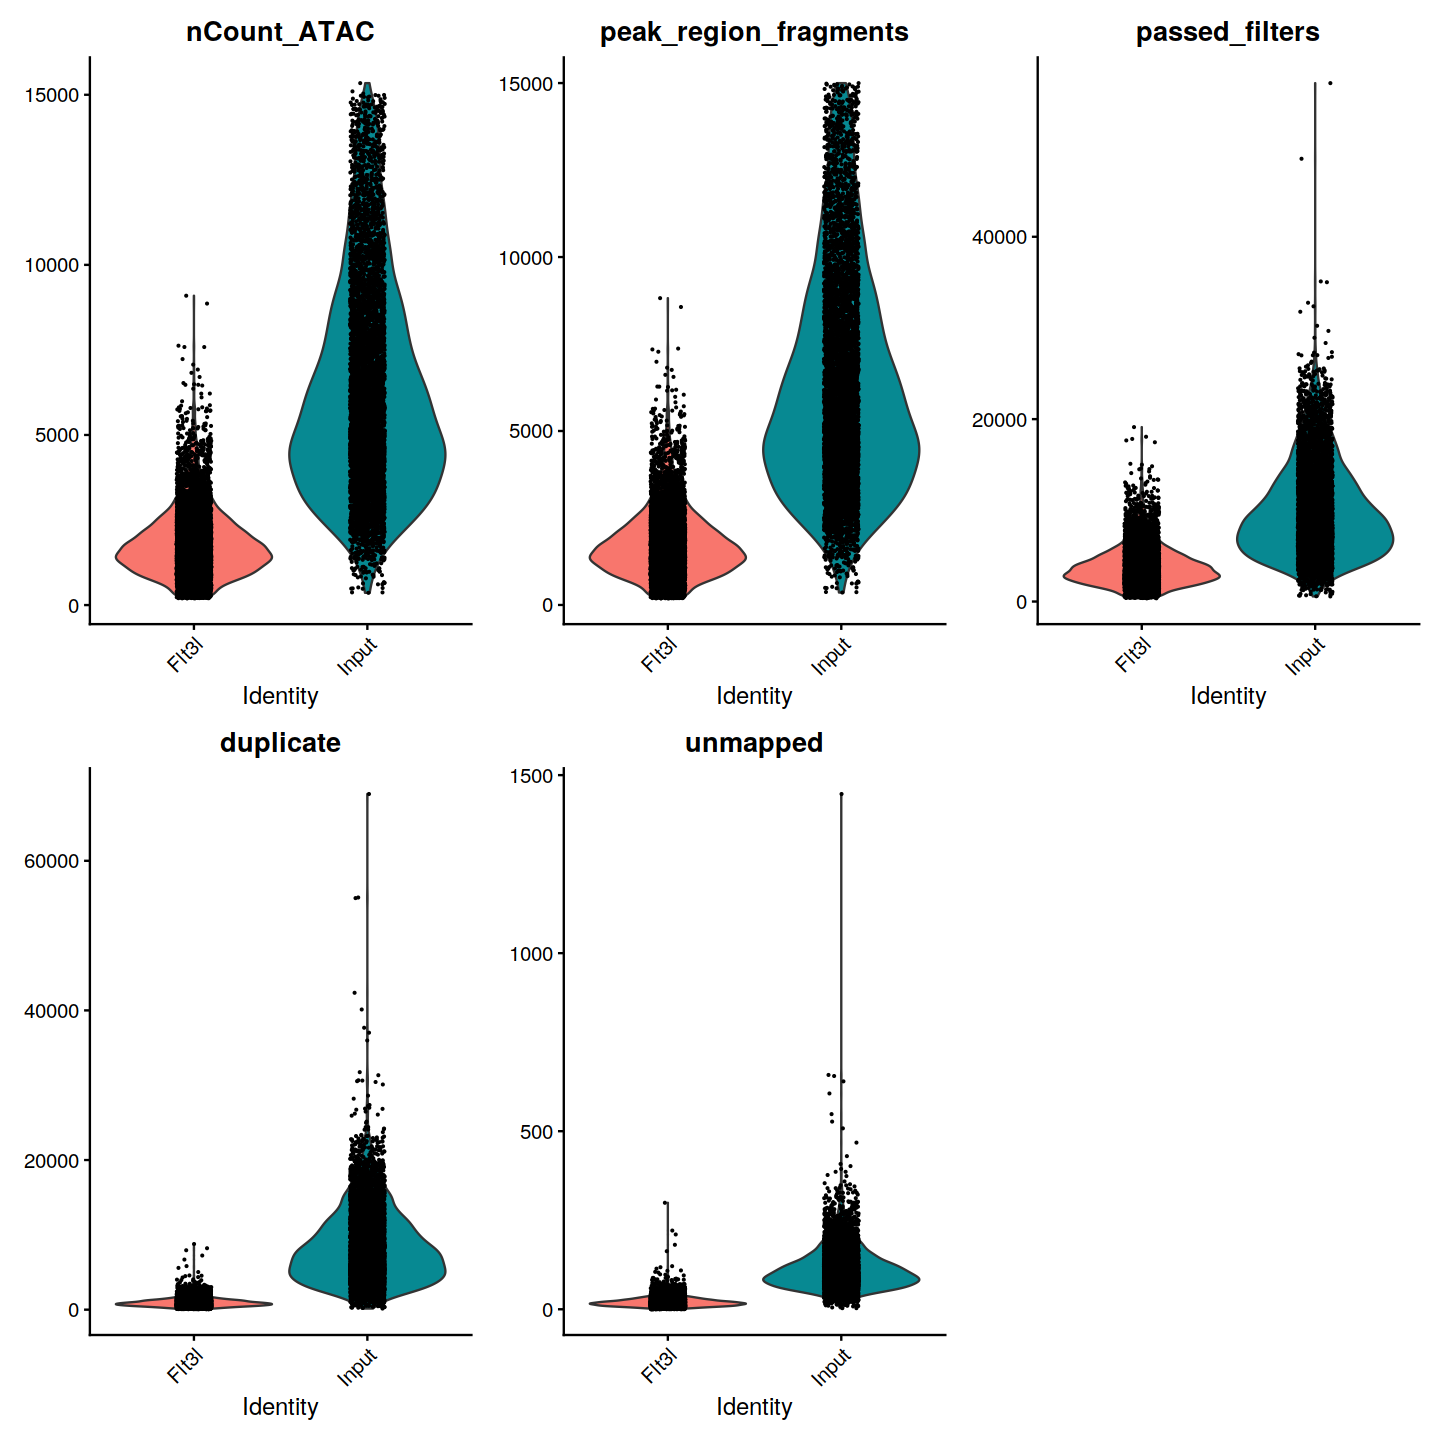

In [16]:
combined$orig.ident <- factor(combined$orig.ident, levels = sample_names)

VlnPlot(
  object = combined,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
16:20:26 UMAP embedding parameters a = 0.9922 b = 1.112

16:20:26 Read 13593 rows and found 49 numeric columns

16:20:26 Using Annoy for neighbor search, n_neighbors = 30

16:20:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:20:28 Writing NN index file to temp file /tmp/Rtmp05tMqV/file7794490c7ee0

16:20:28 Searching Annoy index using 24 threads, search_k = 3000

16:20:28 Annoy recall = 100%

16:20:30 Commencing

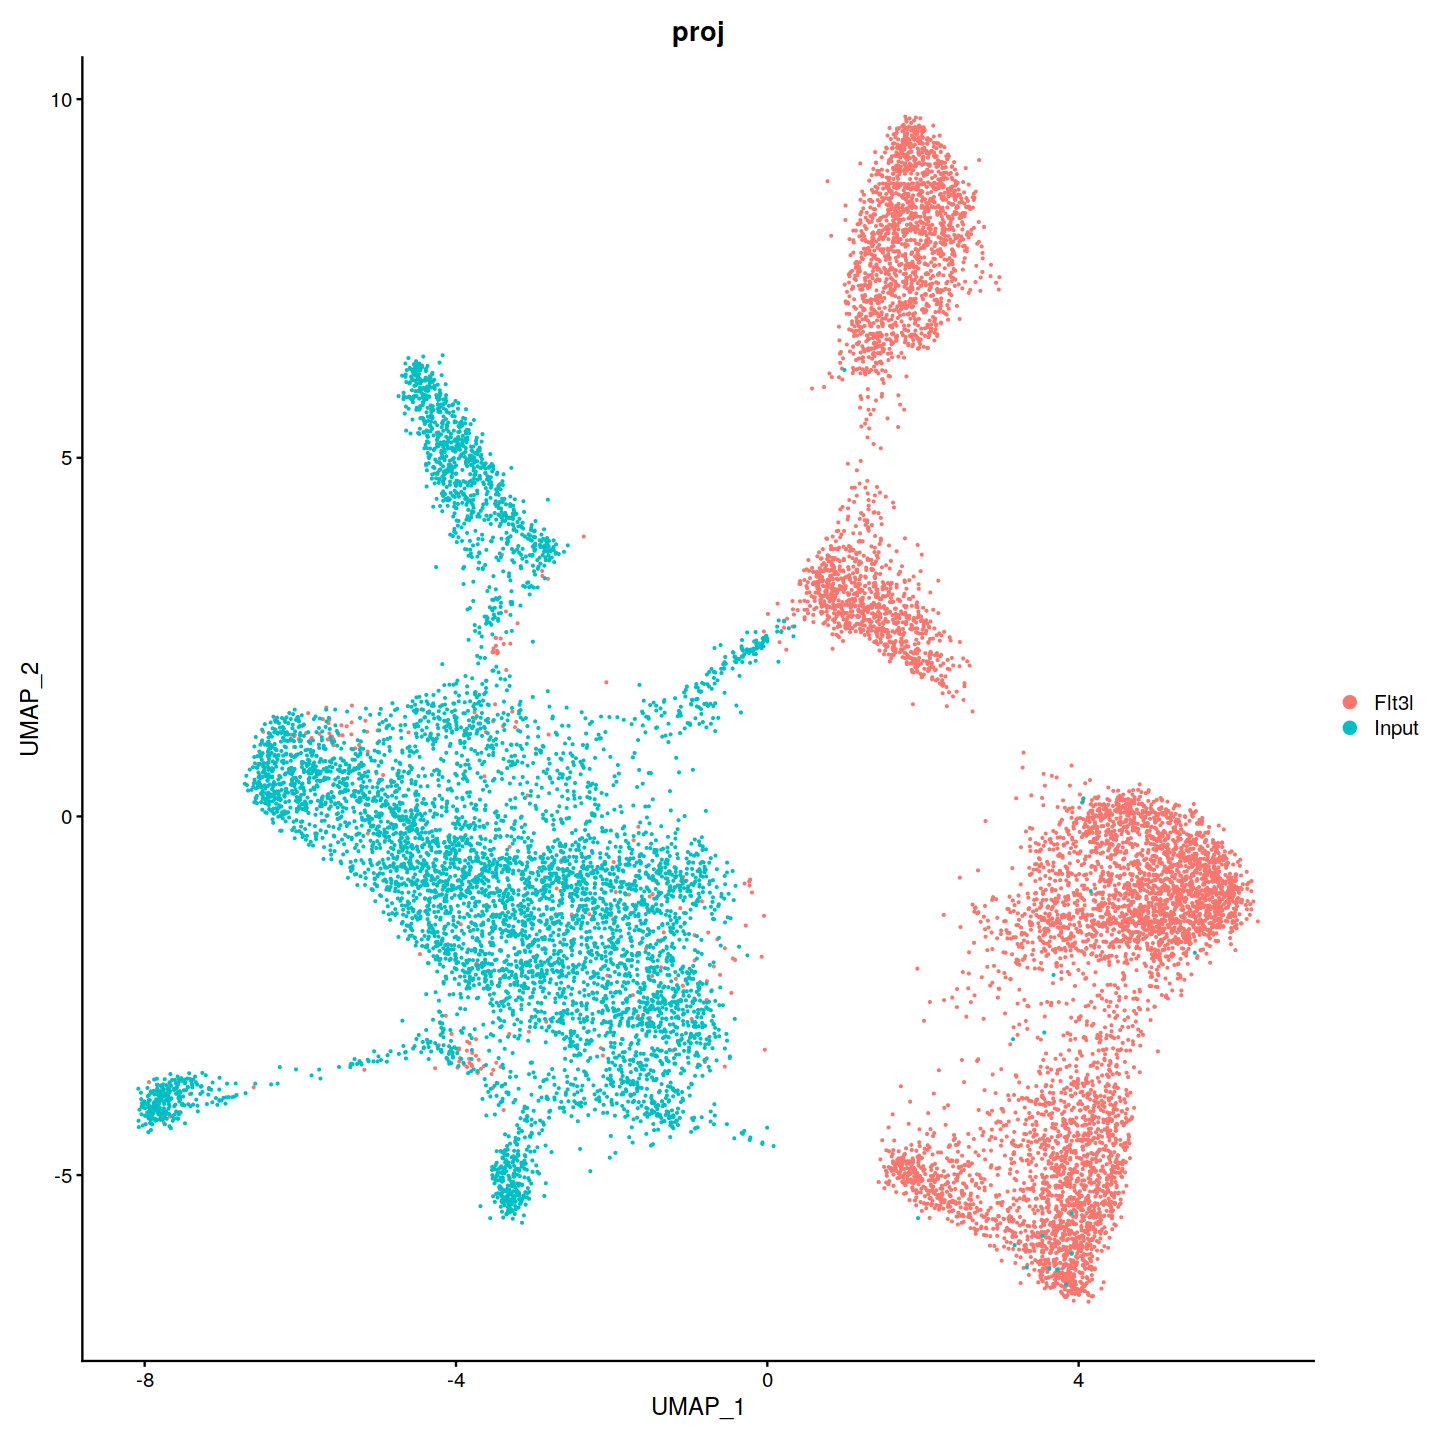

In [17]:
# Binarize and run LSI
combined <- BinarizeCounts(combined)
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = lsi_start_comp:50, reduction = 'lsi')
DimPlot(combined, group.by = "proj", pt.size = 0.1)

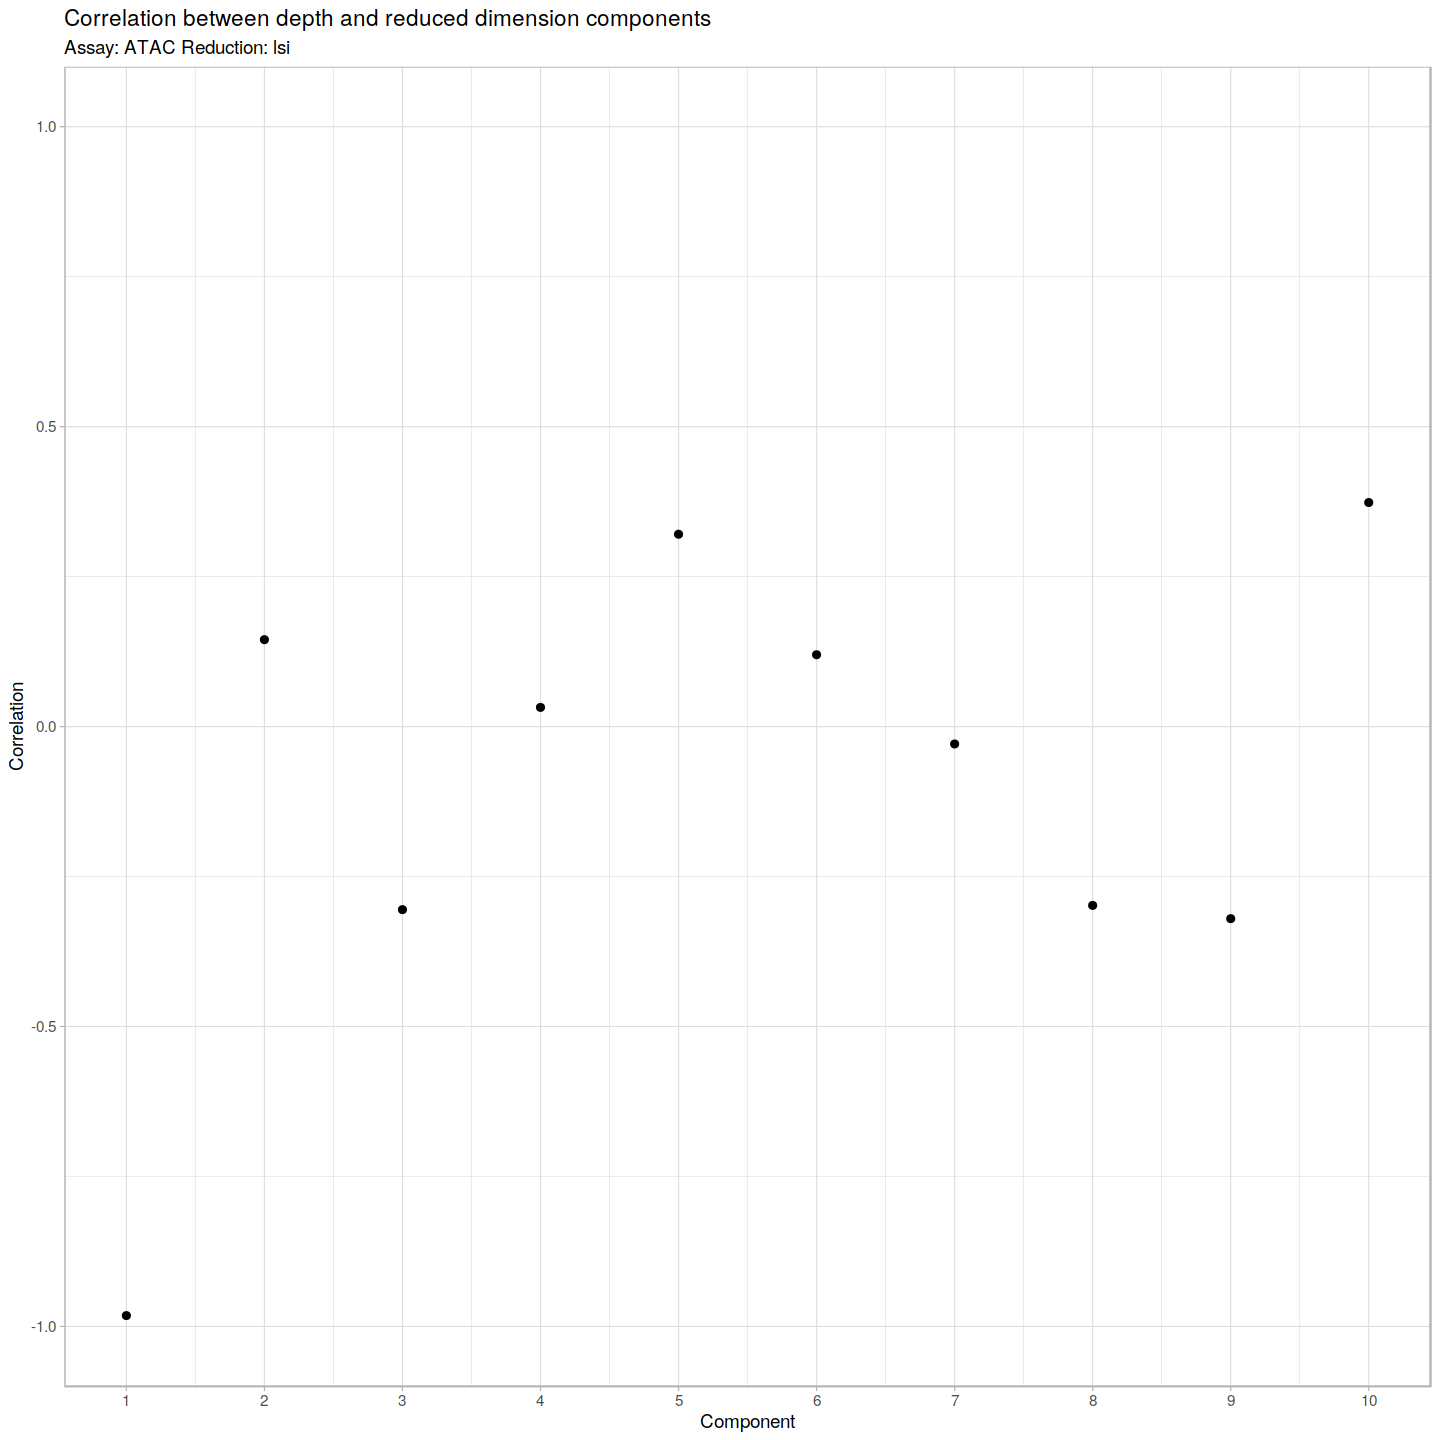

In [18]:
pDepthCorr <- DepthCor(combined)
pDepthCorr

In [19]:
allSE <- lapply(sample_names,  function(x) subset(combined, subset = orig.ident == x))
allSE

[[1]]
An object of class Seurat 
193888 features across 7212 samples within 1 assay 
Active assay: ATAC (193888 features, 182679 variable features)
 2 dimensional reductions calculated: lsi, umap

[[2]]
An object of class Seurat 
193888 features across 6381 samples within 1 assay 
Active assay: ATAC (193888 features, 182679 variable features)
 2 dimensional reductions calculated: lsi, umap


### Plot QC first

In [20]:
vPlot <- function(se){
      vPlot <- VlnPlot(
      object = se,
      features = c('pct_reads_in_peaks', 'peak_region_fragments',
                   'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
      pt.size = 0.1,
      ncol = 5
    )  
    vPlot <- vPlot +    # Create grid of plots with title
             plot_annotation(title = se$orig.ident[[1]]) & 
             theme(plot.title = element_text(hjust = 0.5, size=15))
    #print(vPlot)
    return(vPlot)
}

qc <- function(se){
    # add the gene information to the object
    Annotation(se) <- annotations
    gene.activities <- GeneActivity(se)
    # compute nucleosome signal score per cell
    se <- NucleosomeSignal(object = se)
    
    # compute TSS enrichment score per cell
    se <- TSSEnrichment(object = se, fast = FALSE)

    # add blacklist ratio and fraction of reads in peaks
    se$pct_reads_in_peaks <- se$peak_region_fragments / se$passed_filters * 100
    se$blacklist_ratio <- se$blacklist_region_fragments / se$peak_region_fragments
    se$high.tss <- ifelse(se$TSS.enrichment > 2, 'High', 'Low')
    se$nucleosome_group <- ifelse(se$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
    TSSPlot(se, group.by = 'high.tss') + NoLegend()
    ggsave(file=file.path(outdir, paste0("QC.TSS", se$orig.ident[[1]], ".png")))
    ggsave(file=file.path(outdir, paste0("QC.TSS", se$orig.ident[[1]], ".svg")))
    FragmentHistogram(object = se, group.by = 'nucleosome_group')
    ggsave(file=file.path(outdir, paste0("QC.FragHist", se$orig.ident[[1]], ".png")))
    ggsave(file=file.path(outdir, paste0("QC.FragHist", se$orig.ident[[1]], ".svg")))
    return(se)
}

if (to.qc){
    #ggsave(file.path(outdir, paste0("QC_02.pdf")))
    allSE <- lapply(allSE, qc)
    allSE
    #ggsave(file.path(outdir,"integrated.batch.png"), dpi=300)
    }

# Integrate

In [21]:
if( length(sample_names) == 1){
    integrated = allSE[[1]]
}else{
    # find integration anchors
    integration.anchors <- FindIntegrationAnchors(
      object.list = allSE, #c(ext,curr),
      anchor.features = allSE[[1]], #rownames(ext),
      reduction = "rlsi",
      dims = lsi_start_comp:30
    )

    # integrate LSI embeddings
    integrated <- IntegrateEmbeddings(
      anchorset = integration.anchors,
      reductions = combined[["lsi"]],
      new.reduction.name = "integrated_lsi",
      dims.to.integrate = 2:30
    )
}


Computing within dataset neighborhoods

Finding all pairwise anchors

Warning message:
"No filtering performed if passing to data rather than counts"
Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 3194 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



## Run UMAP and plot

16:22:13 UMAP embedding parameters a = 0.9922 b = 1.112

16:22:13 Read 13593 rows and found 29 numeric columns

16:22:13 Using Annoy for neighbor search, n_neighbors = 30

16:22:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:22:14 Writing NN index file to temp file /tmp/Rtmp05tMqV/file7794418cda5d

16:22:14 Searching Annoy index using 24 threads, search_k = 3000

16:22:14 Annoy recall = 100%

16:22:16 Commencing smooth kNN distance calibration using 24 threads

16:22:20 Initializing from normalized Laplacian + noise

16:22:20 Commencing optimization for 200 epochs, with 580826 positive edges

16:22:29 Optimization finished

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



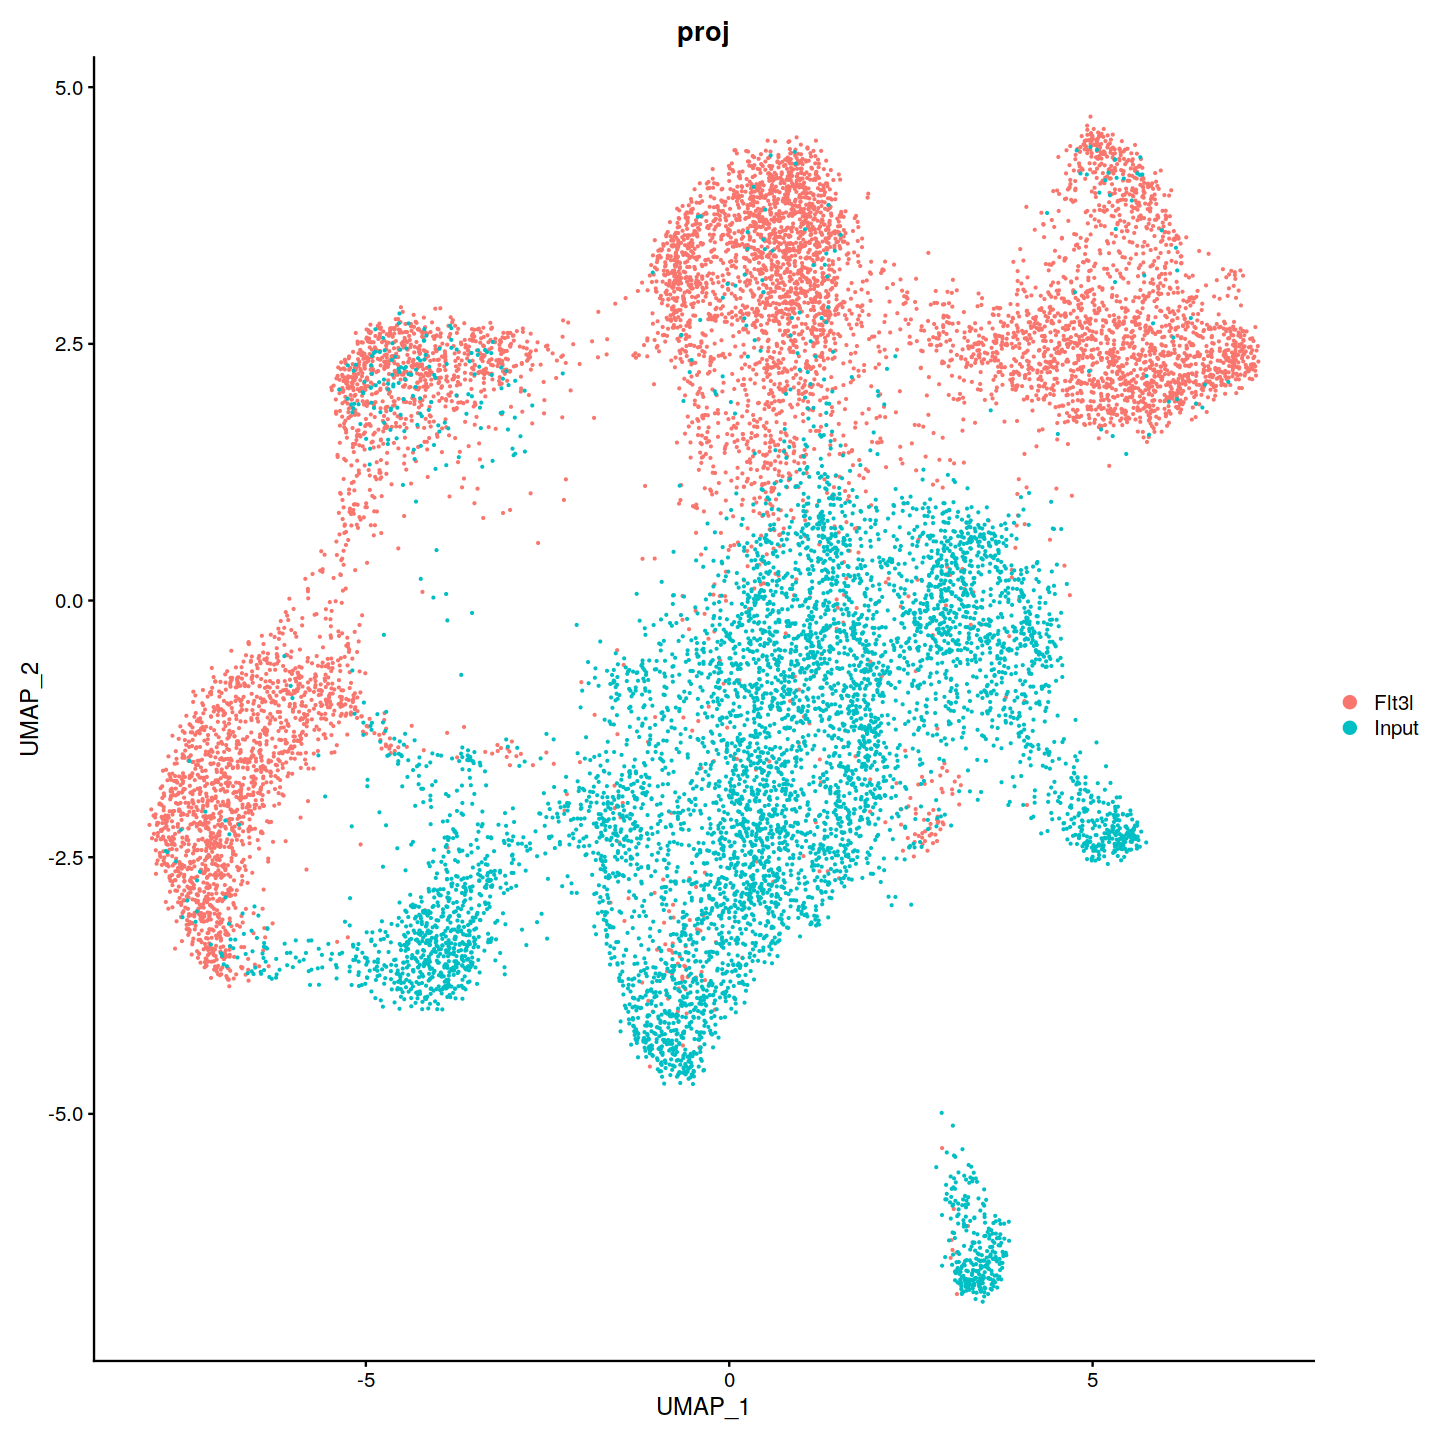

In [22]:
p1 <- DimPlot(combined, group.by = "proj")

# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "proj")
ggsave(file.path(outdir,"integrated.batch.png"), dpi=300)
ggsave(file.path(outdir,"integrated.batch.svg"), dpi=300)
ggsave(file.path(outdir,"integrated.batch.pdf"), dpi=300)
p2

### Compare merged and integrated

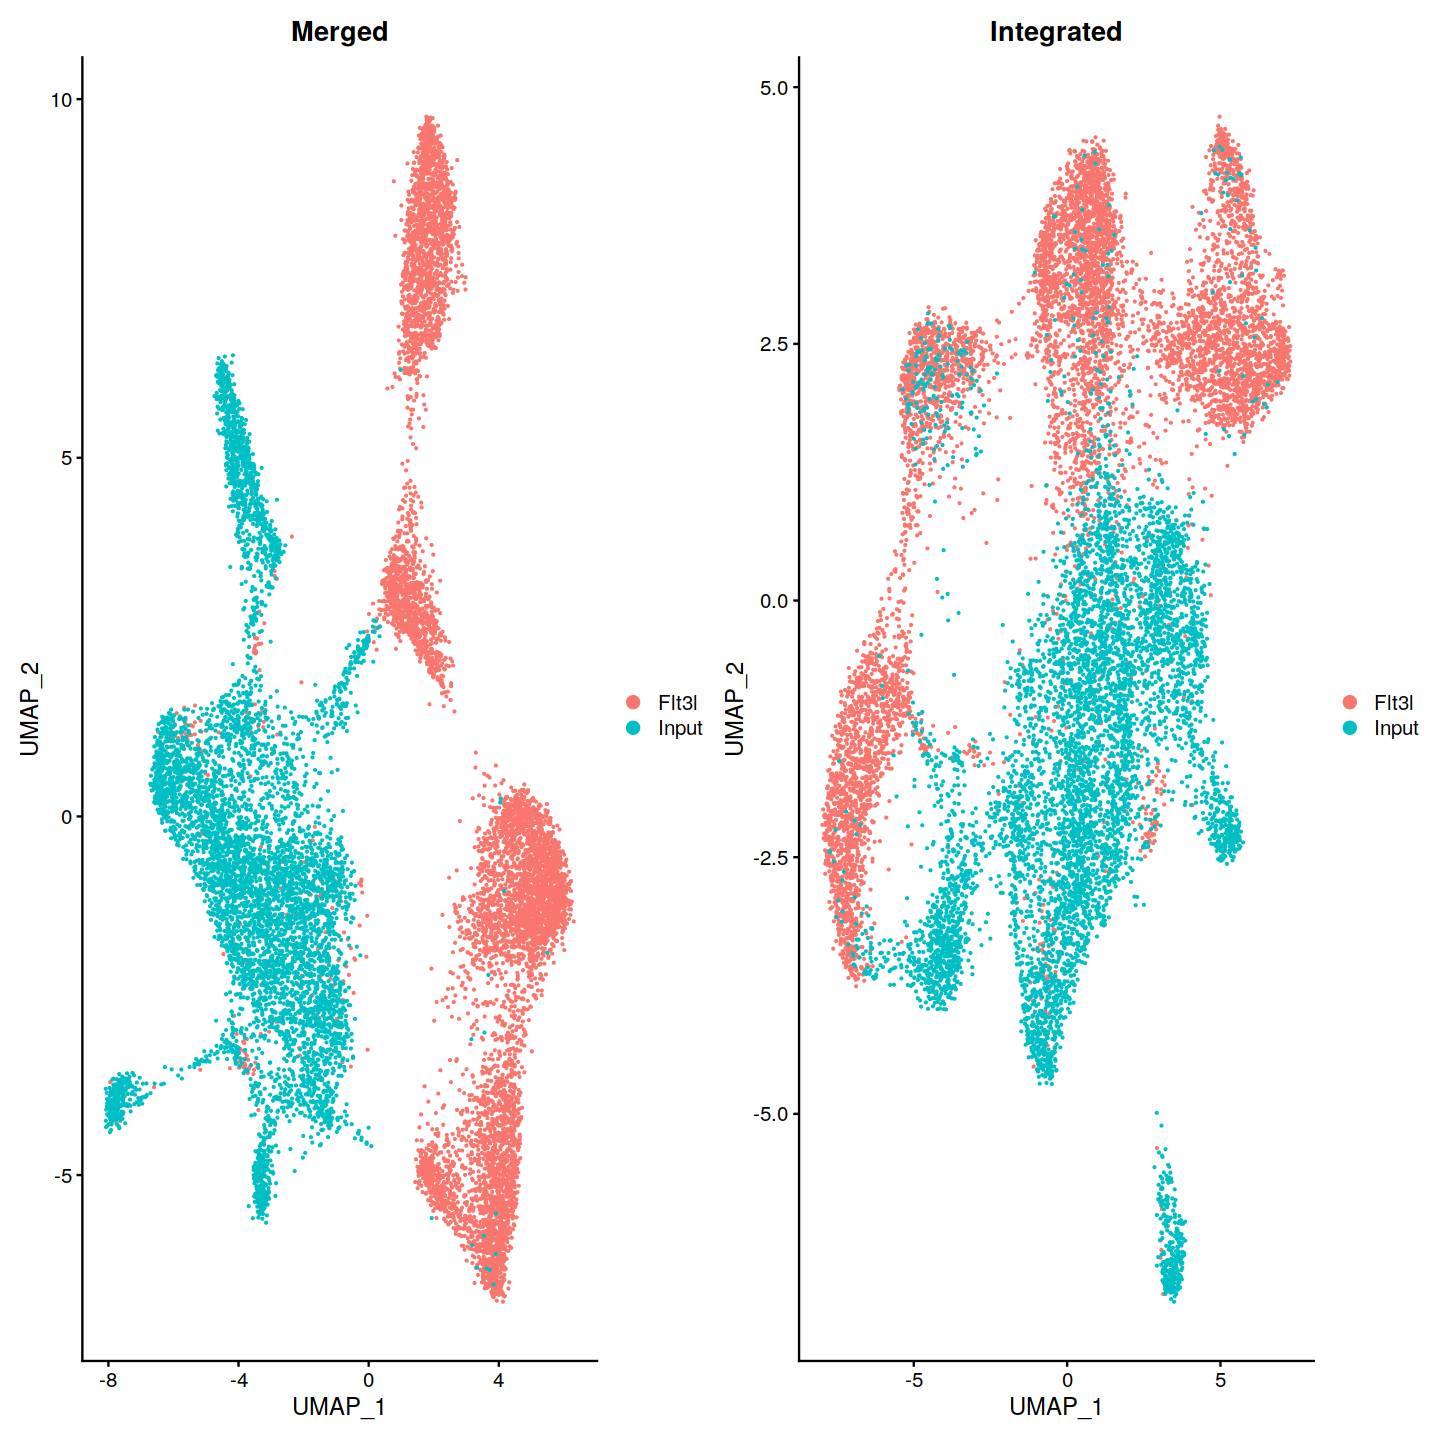

In [23]:
(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))
ggsave(file.path(outdir,"integrated.merged.compare.png"), width = 32, height=32)
ggsave(file.path(outdir,"integrated.merged.compare.pdf"), width = 32, height=32)

## Correlation of LSI components and Depth

Saving 6.67 x 6.67 in image

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"


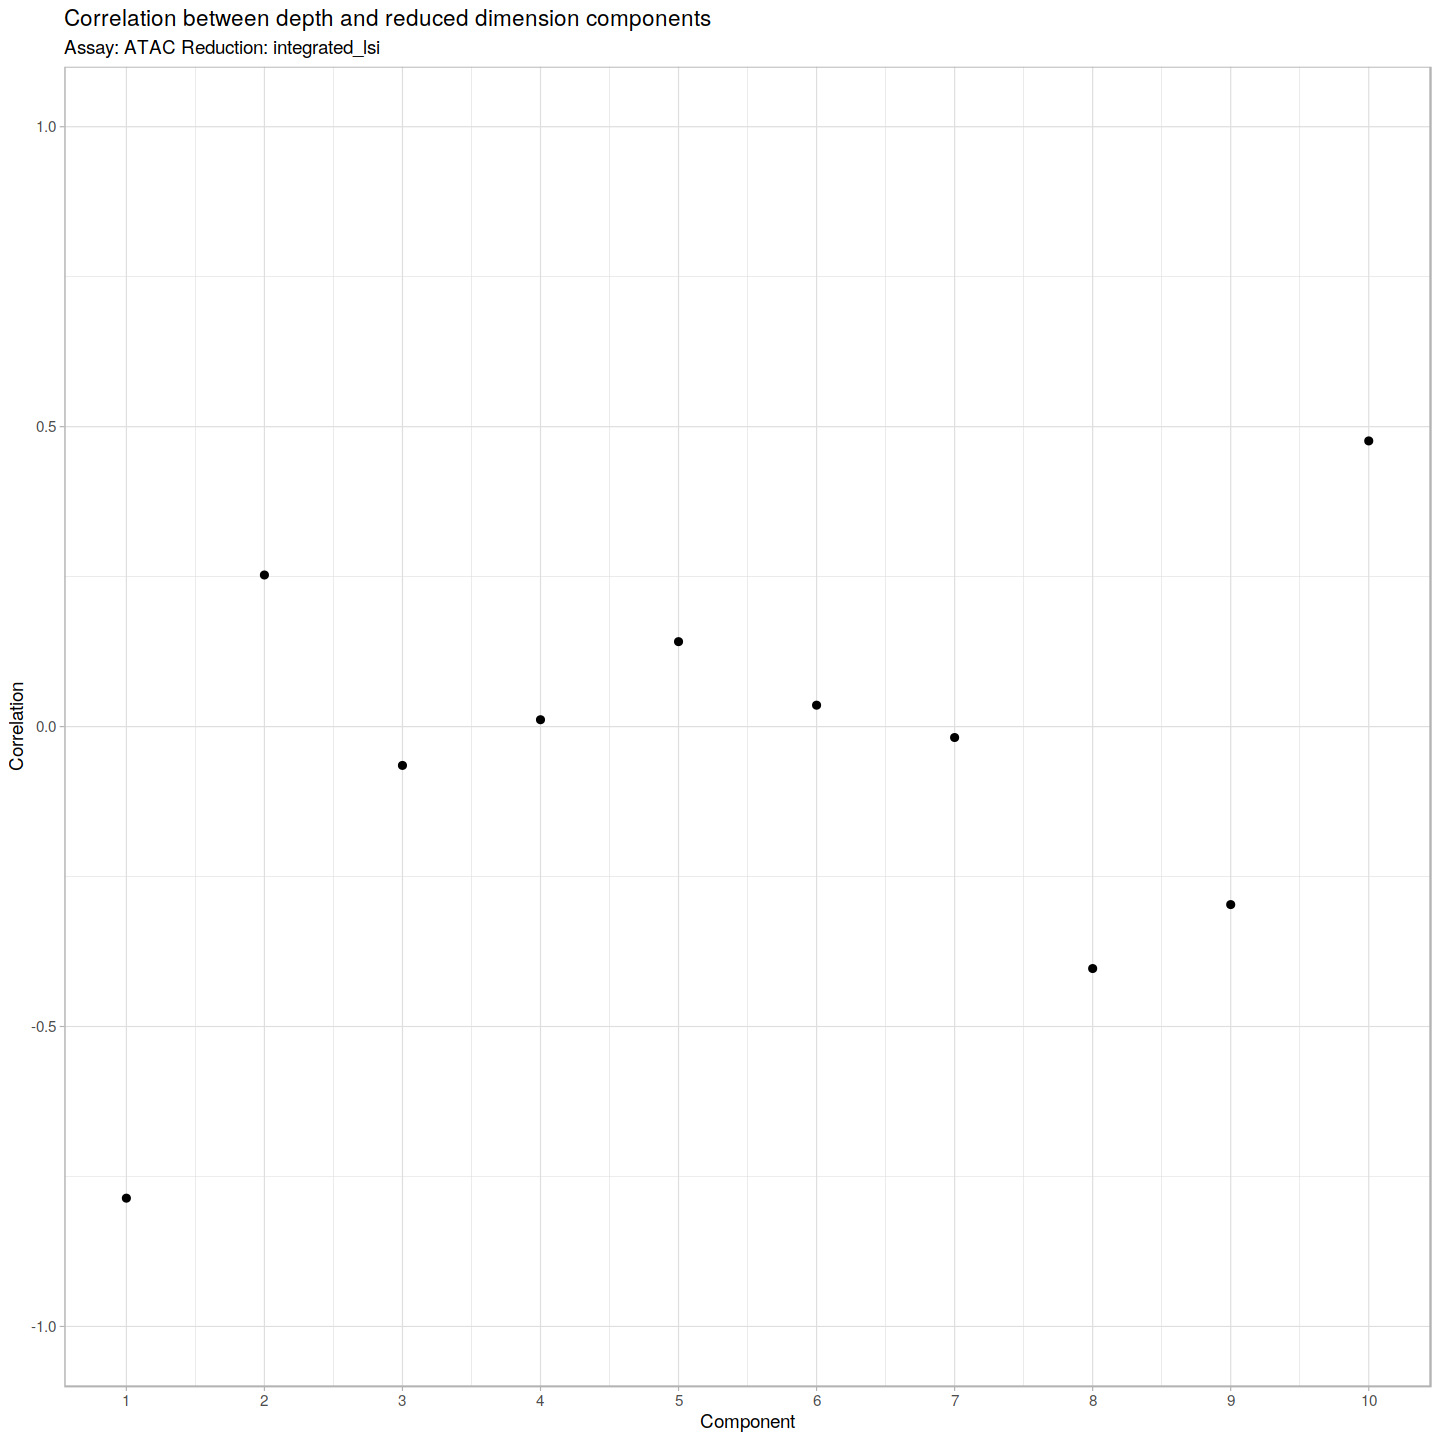

In [24]:
pDepthCorr <- DepthCor(integrated, reduction='integrated_lsi')
ggsave(file.path(outdir,"integrated.depthCor.png"), plot=pDepthCorr, dpi=300)
#ggsave(file.path(outdir,"integrated.depthCor.svg"), plot=pDepthCorr, width=16, height=16)
ggsave(file.path(outdir,"integrated.depthCor.pdf"), plot=pDepthCorr, width=16, height=16)

pDepthCorr

## Cluster and plot

Computing nearest neighbor graph

Computing SNN

Warning message:
"UNRELIABLE VALUE: One of the 'future.apply' iterations ('future_lapply-1') unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore"."
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



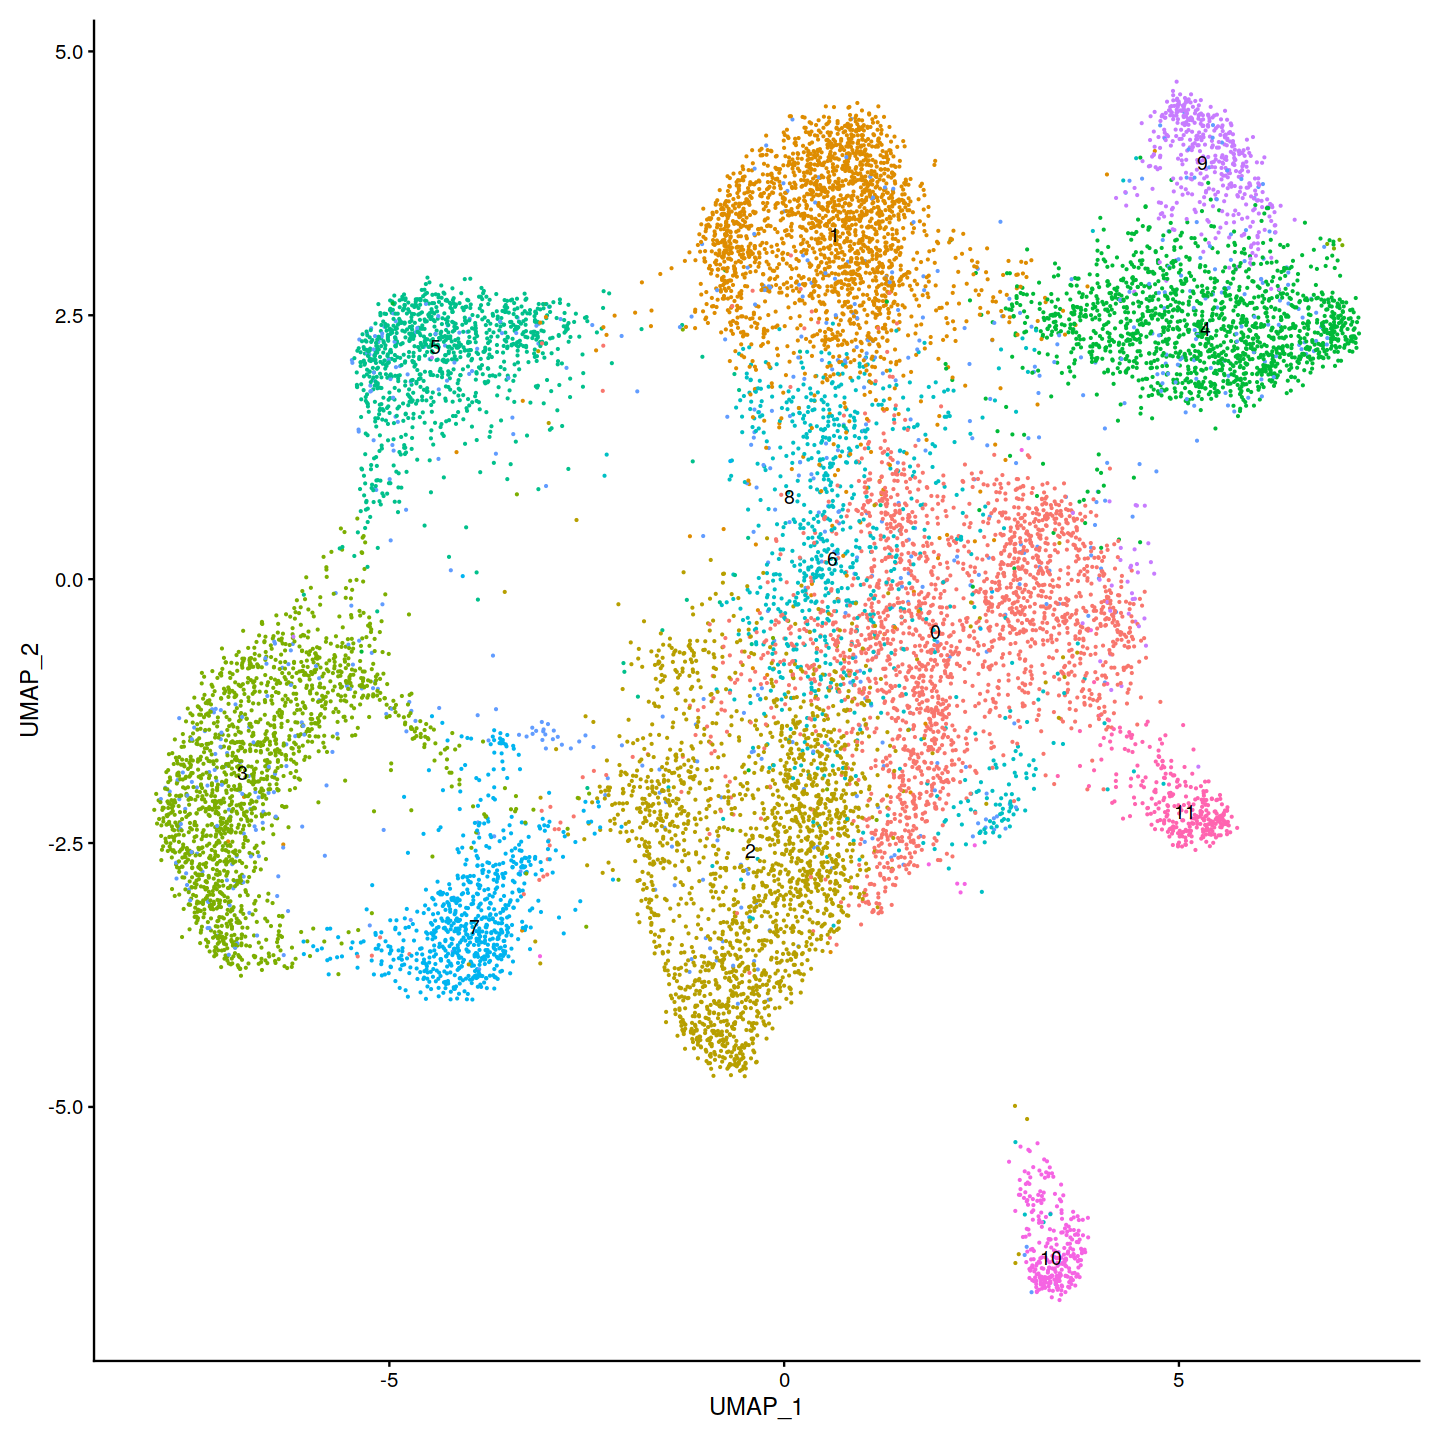

In [25]:
#integrated <- RunUMAP(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindNeighbors(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindClusters(object = integrated, verbose = FALSE, algorithm = 3)

pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
ggsave(file.path(outdir, "integrated.lsi.clusters.png"), pclust)
ggsave(file.path(outdir, "integrated.lsi.clusters.svg"), pclust)
ggsave(file.path(outdir, "integrated.lsi.clusters.pdf"), pclust)


pclust

## Get gene activity results 

In [26]:
# add the gene information to the object
DefaultAssay(integrated) <- "ATAC"
Annotation(integrated) <- annotations
gene.activities <- GeneActivity(integrated)


Extracting gene coordinates



ERROR: Error in GeneActivity(integrated): No fragment information found for requested assay


## Remove MT genes

In [ ]:
mt_genes <- annotations[seqnames(annotations) == "chrM"]
dim(mt_genes)


In [ ]:
dim(gene.activities)

In [ ]:
gene.activities <- gene.activities[!(rownames(gene.activities) %in% mt_genes$gene_name),]

In [ ]:
dim(gene.activities)

In [ ]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
integrated[['RNA']] <- CreateAssayObject(counts = gene.activities)
integrated <- NormalizeData(
  object = integrated,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(integrated$nCount_RNA)
)

In [ ]:
DefaultAssay(integrated) <- 'RNA'

In [ ]:
saveRDS(integrated, file.path(outdir, paste0("allSamples.integrated.rds")))

In [ ]:
Idents(integrated) <- "orig.ident"
VlnPlot(
  object = integrated,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)

ggsave(file.path(outdir, paste0("QC_02.png")))
ggsave(file.path(outdir, paste0("QC_02.svg")))

In [ ]:
sessionInfo()